In [12]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.samplers import TPESampler

import lightgbm as lgb
import xgboost as xgb

from sklearn.pipeline import Pipeline

from src.model_validation import TSCrossValidate, summary_evaluation, fold_evaluation
from src.model_helpers import DailyModel
from src.sharpe import score_sharpe
from src.features import FeatureEng

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [21]:
df = pd.read_csv("data_raw/train.csv")

df = df[df["date_id"] > 1000].copy()
df.head()

date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  E1  E10  E11  E12  E13  \
1001     1001   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN   
1002     1002   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN   
1003     1003   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN   
1004     1004   1   1   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN   
1005     1005   0   0   0   1   0  -1   0   0   0 NaN  NaN  NaN  NaN  NaN   

      E14  E15  E16  E17  E18  E19  E2  E20  E3  E4  E5  E6  E7  E8  E9  I1  \
1001  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1002  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1003  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1004  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1005  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   

      I2  I3  I4  I5  I6  I7  I8  I9  M1  M10  M11  M12  M13  M14  M15  M16  \
1001 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1002 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1003 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1004 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1005 NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

      M17  M18  M2  M3  M4  M5  M6  M7  M8  M9  P1  P10  P11  P12  P13  P2  \
1001  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   
1002  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   
1003  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   
1004  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   
1005  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN  NaN NaN   

      P3  P4  P5  P6  P7  P8  P9  S1  S10  S11  S12  S2  S3  S4  S5  S6  S7  \
1001 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   
1002 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   
1003 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   
1004 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   
1005 NaN NaN NaN NaN NaN NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN   

      S8  S9  V1  V10  V11  V12  V13  V2  V3  V4  V5  V6  V7  V8  V9  \
1001 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1002 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1003 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1004 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1005 NaN NaN NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN   

      forward_returns  risk_free_rate  market_forward_excess_returns  
1001         0.003361        0.000120                       0.002932  
1002         0.005496        0.000120                       0.005066  
1003         0.001342        0.000120                       0.000912  
1004        -0.003350        0.000121                      -0.003781  
1005         0.006725        0.000122                       0.006293

In [6]:
TARGET = "market_forward_excess_returns"
DROP = ['is_scored', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
FEATURES = [c for c in df.columns if c not in DROP]

In [7]:
ts_folds = TimeSeriesSplit(n_splits=10, test_size=180)

In [8]:
processing = Pipeline([("imputer", tml.DfImputer(strategy="constant", fill_value=0)), ("scaler", tml.DfScaler())])

In [9]:
def add_streak_features(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Add rolling features counting consecutive positive/negative streaks.
    
    Args:
        df: DataFrame with the column to analyze
        column: Name of the column to track streaks for
    
    Returns:
        DataFrame with added streak columns
    """
    df = df.copy()

    df["temp_col"] = df[column].shift()
    
    # Create binary indicators for positive/negative
    df['_is_positive'] = (df["temp_col"] > 0).astype(int)
    df['_is_negative'] = (df["temp_col"] < 0).astype(int)
    
    # Create streak groups (changes when sign changes)
    df['_pos_streak_group'] = (df['_is_positive'] != df['_is_positive'].shift()).cumsum()
    df['_neg_streak_group'] = (df['_is_negative'] != df['_is_negative'].shift()).cumsum()
    
    # Count consecutive occurrences within each group
    df[f'{column}_positive_streak'] = df.groupby('_pos_streak_group')['_is_positive'].cumsum() * df['_is_positive']
    df[f'{column}_negative_streak'] = df.groupby('_neg_streak_group')['_is_negative'].cumsum() * df['_is_negative']
    
    # Clean up temporary columns
    df = df.drop(columns=['_is_positive', '_is_negative', '_pos_streak_group', '_neg_streak_group', "temp_col"])
    
    return df


def make_lags_train(data):
    df = data.copy()

    targets = ['forward_returns', 'risk_free_rate']

    for col in targets:
        for lag in [1, 5, 22]:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
        
        for w in [5, 22, 220]:
            df[f"{col}_mean_{w}"] = df[col].shift(1).rolling(w, min_periods=w).mean()
            df[f"{col}_std_{w}"] = df[col].shift(1).rolling(w, min_periods=w).std()

        if col == "forward_returns":
            df = add_streak_features(df, col)

    return df

# Linear Model

In [22]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "alpha": trial.suggest_float("alpha", 1, 100),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.1, 1),
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "conversion": trial.suggest_int("conversion", 1, 1000),
        "u1": trial.suggest_categorical("u1", [True, False]),
        "u2": trial.suggest_categorical("u2", [True, False]),
        "add_ts": trial.suggest_categorical("add_ts", [True, False]),
        "riskadj_m4": trial.suggest_categorical("riskadj_m4", [True, False]),
        "quant_p11": trial.suggest_categorical("quant_p11", [True, False]),
        "fed_model": trial.suggest_categorical("fed_model", [True, False]),
        "glob_vol": trial.suggest_categorical("glob_vol", [True, False]),
        "relmom": trial.suggest_categorical("relmom", [True, False]),
        "mom_div": trial.suggest_categorical("mom_div", [True, False]),
        "mompersistence": trial.suggest_categorical("mompersistence", [True, False]),
        "mom_regime": trial.suggest_categorical("mom_regime", [True, False]),
        "vol_spread": trial.suggest_categorical("vol_spread", [True, False]),
        "price_mom": trial.suggest_categorical("price_mom", [True, False]),
        "rate_sens": trial.suggest_categorical("rate_sens", [True, False]),
    }
    processing = Pipeline([("fe", FeatureEng(u1=param["u1"], u2=param["u2"], add_ts=param["add_ts"],
                                             riskadj_m4=param["riskadj_m4"], quant_p11=param["quant_p11"], fed_model=param["fed_model"],
                                             glob_vol=param["glob_vol"], relmom=param["relmom"], mom_div=param["mom_div"],
                                             mompersistence=param["mompersistence"], momregime=param["mom_regime"], vol_spread=param["vol_spread"],
                                             price_mom=param["price_mom"], rate_sens=param["rate_sens"])),
                            ("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                            ("scaler", tml.DfScaler())])
    
    train = make_lags_train(data)

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = ElasticNet(alpha=param["alpha"], l1_ratio=param["l1_ratio"], random_state=325)

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id"}
    else:
        fit_params = {}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"] * param["conversion"] + 1, 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [23]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 200
Best trial: {'alpha': 55.06190165981601, 'l1_ratio': 0.41195164758511454, 'strategy': 'constant', 'sample_weight': False, 'conversion': 1, 'u1': True, 'u2': True, 'add_ts': False, 'riskadj_m4': True, 'quant_p11': False, 'fed_model': True, 'glob_vol': False, 'relmom': True, 'mom_div': True, 'mompersistence': True, 'mom_regime': True, 'vol_spread': True, 'price_mom': False, 'rate_sens': False}


In [24]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
108     108  0.640611 2025-12-02 21:29:53.810488 2025-12-02 21:30:15.188578   
183     183  0.640611 2025-12-02 21:31:36.401830 2025-12-02 21:31:59.713215   
181     181  0.640611 2025-12-02 21:31:33.831681 2025-12-02 21:31:57.472294   
119     119  0.640611 2025-12-02 21:30:08.292324 2025-12-02 21:30:28.934800   
115     115  0.640611 2025-12-02 21:30:00.355115 2025-12-02 21:30:22.951973   
162     162  0.640611 2025-12-02 21:31:04.388940 2025-12-02 21:31:24.941577   
159     159  0.640611 2025-12-02 21:31:00.604512 2025-12-02 21:31:21.285477   
46       46  0.640611 2025-12-02 21:28:34.548351 2025-12-02 21:28:52.484561   
45       45  0.640611 2025-12-02 21:28:33.896656 2025-12-02 21:28:52.411876   
103     103  0.640611 2025-12-02 21:29:45.678038 2025-12-02 21:30:08.578195   

                  duration  params_add_ts  params_alpha  params_conversion  \
108 0 days 00:00:21.378090           True     54.999200                  1   
183 0 days 00:00:23.311385           True     83.311599                  1   
181 0 days 00:00:23.640613           True     80.134918                  1   
119 0 days 00:00:20.642476           True     19.273559                  1   
115 0 days 00:00:22.596858           True     52.350750                  1   
162 0 days 00:00:20.552637           True     50.910321                  1   
159 0 days 00:00:20.680965           True     49.876034                  1   
46  0 days 00:00:17.936210          False     55.152794                  1   
45  0 days 00:00:18.515220          False     55.061902                  1   
103 0 days 00:00:22.900157           True     20.497524                  1   

     params_fed_model  params_glob_vol  params_l1_ratio  params_mom_div  \
108              True            False         0.427173            True   
183              True            False         0.421217            True   
181              True            False         0.417598            True   
119              True            False         0.380438            True   
115              True            False         0.382366            True   
162              True            False         0.447309            True   
159              True            False         0.455410            True   
46               True            False         0.436370            True   
45               True            False         0.411952            True   
103              True            False         0.520064            True   

     params_mom_regime  params_mompersistence  params_price_mom  \
108               True                  False             False   
183               True                  False             False   
181               True                  False             False   
119              False                  False             False   
115              False                  False             False   
162               True                  False             False   
159               True                  False             False   
46                True                   True             False   
45                True                   True             False   
103               True                  False             False   

     params_quant_p11  params_rate_sens  params_relmom  params_riskadj_m4  \
108              True             False           True               True   
183              True              True           True              False   
181              True              True           True              False   
119              True              True           True              False   
115              True              True           True              False   
162              True              True           True              False   
159              True              True           True              False   
46              False             False           True               True   
45              Fal

In [25]:
optuna.visualization.plot_optimization_history(study)

In [26]:
optuna.visualization.plot_param_importances(study)

In [27]:
optuna.visualization.plot_contour(study, params=['conversion', 'alpha', 'l1_ratio'])

Mean Squared Error: 0.00012
R2: -0.0002802998318685024
MAE: 0.007926483420219316
               min      mean       max
fold                                  
0     1.128986e-09  0.000110  0.001546
1     3.756913e-10  0.000061  0.000928
2     2.868247e-09  0.000322  0.001625
3     6.450893e-10  0.000079  0.001192
4     4.656548e-10  0.000103  0.000891
5     4.027684e-10  0.000246  0.001643
6     1.918253e-09  0.000078  0.000624
7     6.923932e-12  0.000054  0.000406
8     6.187906e-10  0.000069  0.000920
9     5.237794e-10  0.000117  0.001651
Sharpe: 0.6406138329391244
0 -0.223030977633935
1 1.6085672096963926
2 0.6296779306039075
3 2.478625781847355
4 0.41391984750396926
5 -0.8081853233853052
6 0.9798122875098716
7 1.6283334390047337
8 1.0719220611164577
9 0.614819316362808


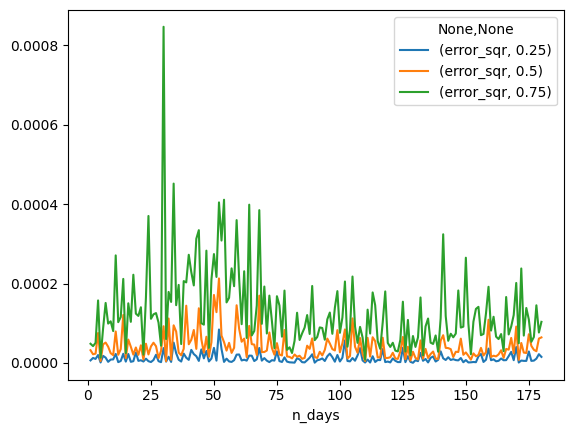

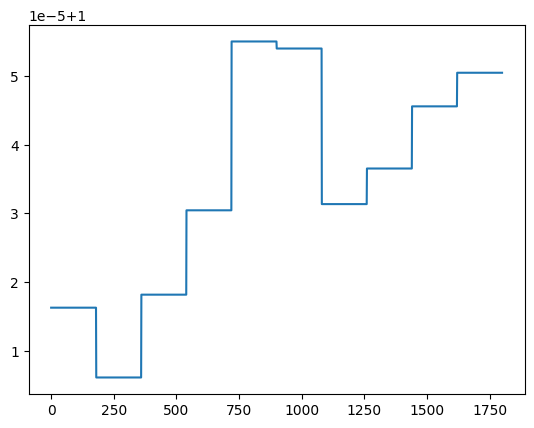

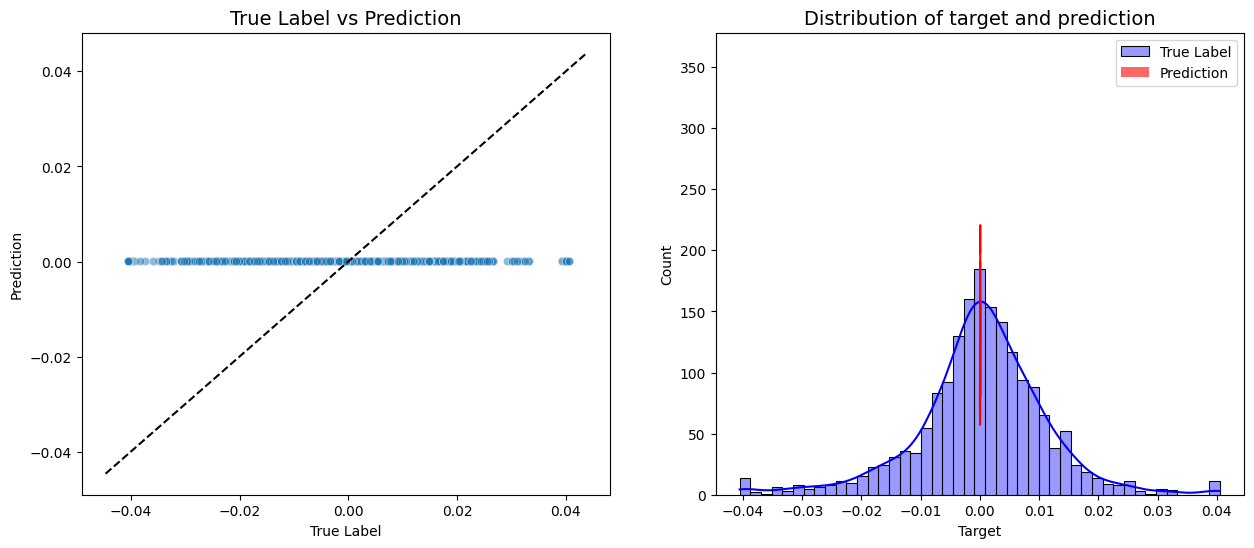

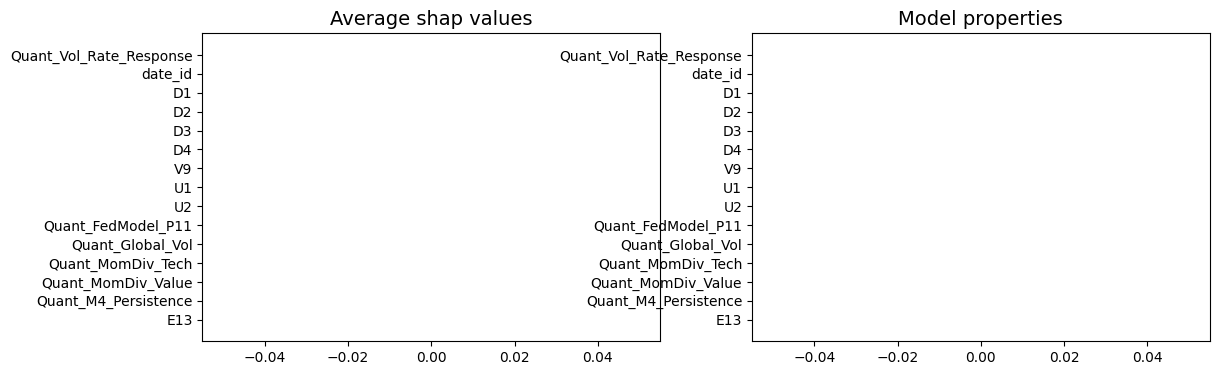

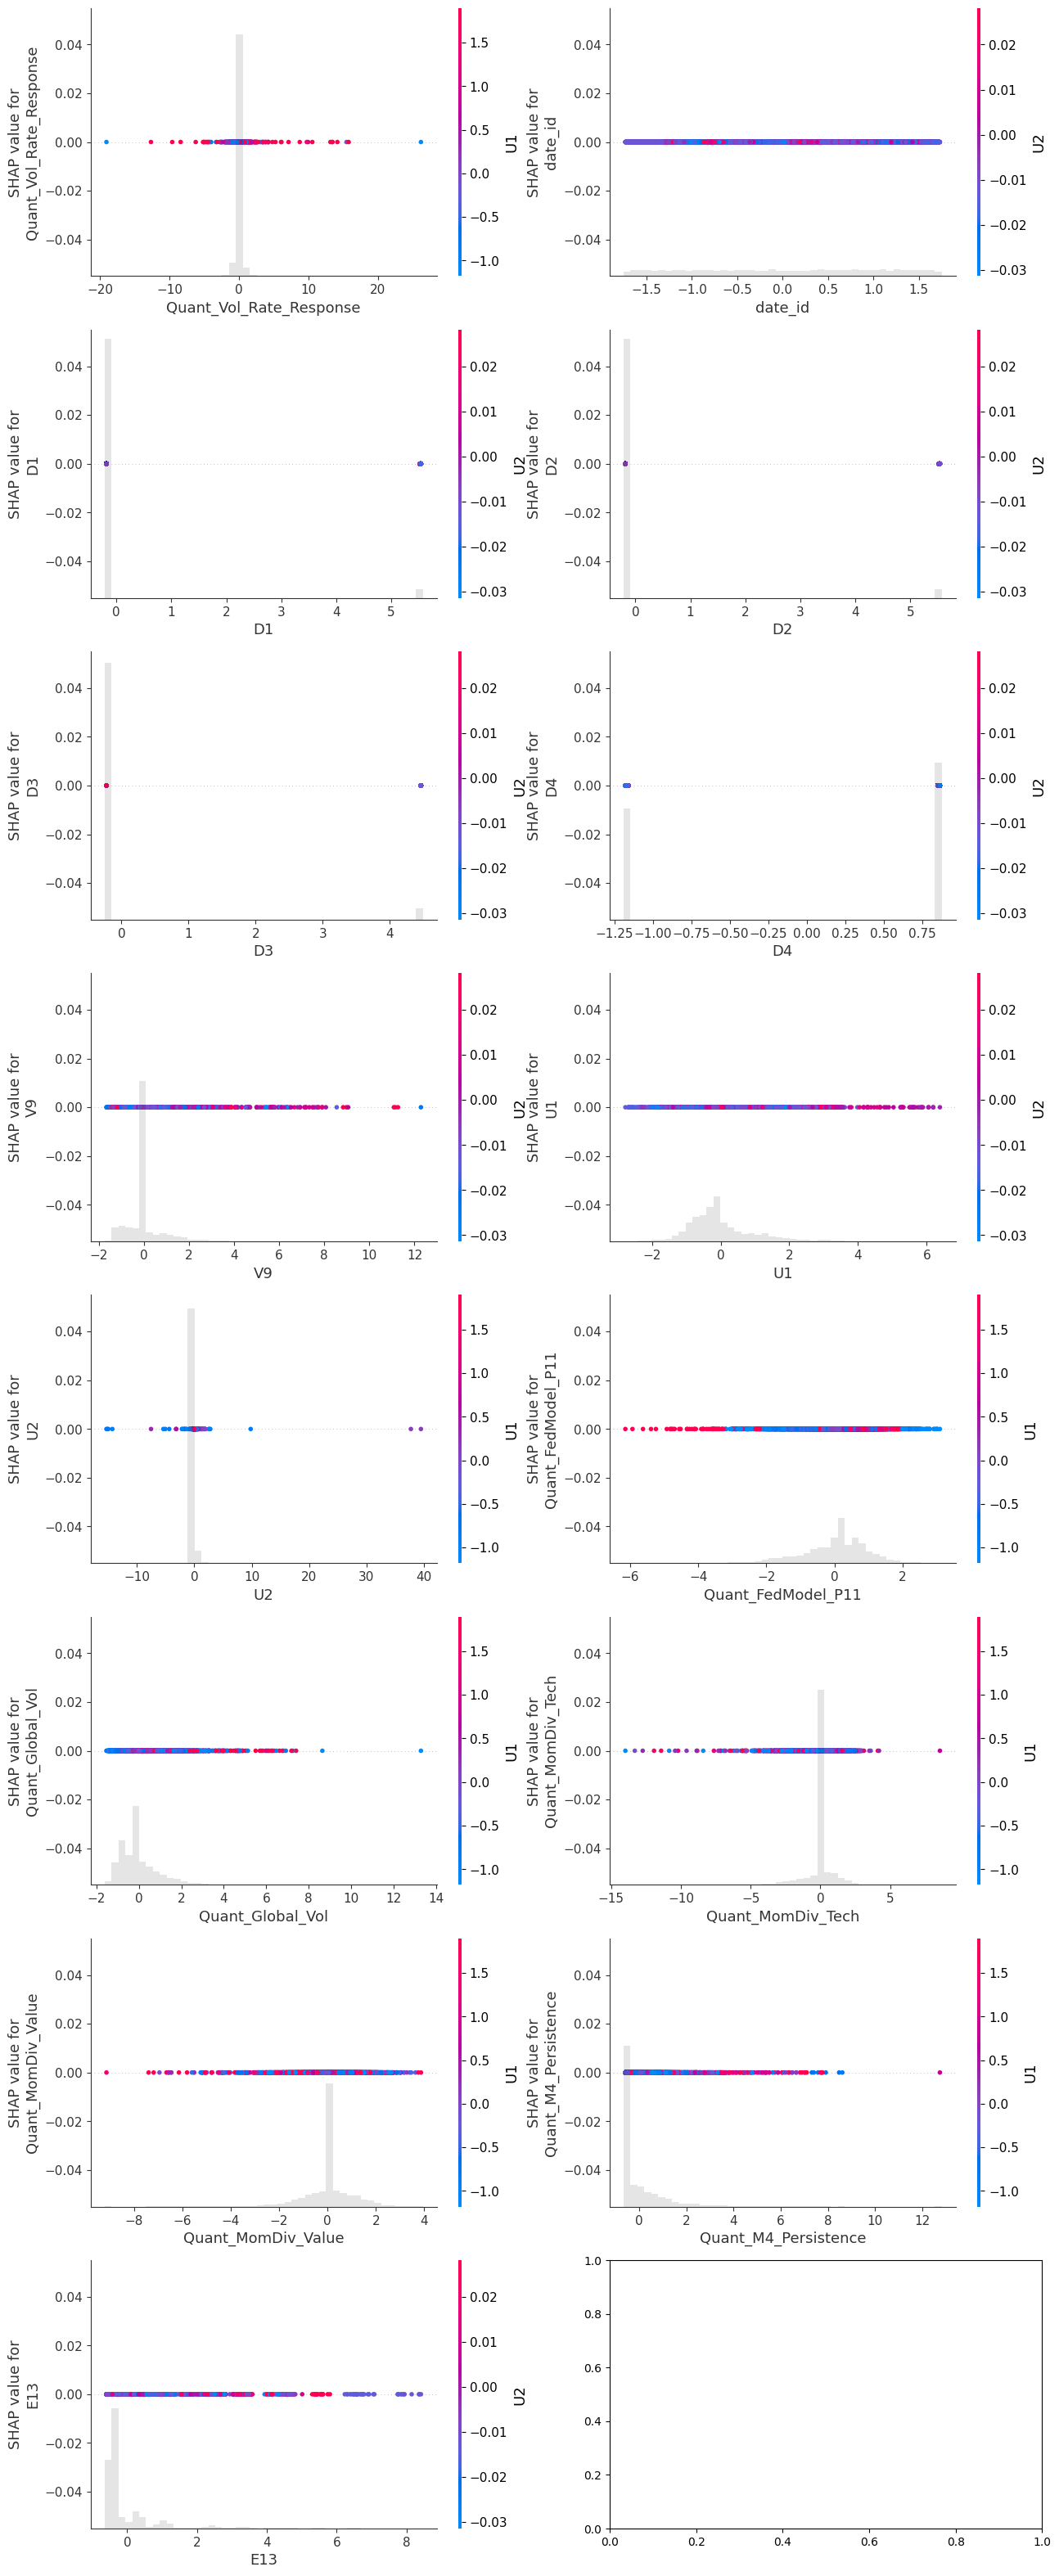

In [7]:
model = ElasticNet(alpha=51, l1_ratio=0.47, random_state=325)

processing = Pipeline([("fe", FeatureEng(u1=True, u2=True, add_ts=False,
                                             riskadj_m4=False, quant_p11=False, fed_model=True,
                                             glob_vol=True, relmom=False, mom_div=True,
                                             mompersistence=True, momregime=True, vol_spread=True,
                                             price_mom=True, rate_sens=True)),
                            ("imputer", tml.DfImputer(strategy="median", fill_value=0)),
                            ("scaler", tml.DfScaler())])

pipe = Pipeline([("processing", processing),
                ("model", model)])

fit_params = {"sample_weight": "date_id"}


FEATURES = [c for c in df.columns if c not in DROP]

cvscore = TSCrossValidate(data=df[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True)
oof, res = cvscore.score()

summary_evaluation(res["folds_eval"], df, factor=1)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(15)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

# RandomForest

In [13]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", 0.8]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
        "create_features": trial.suggest_categorical("create_features", [True, False]),
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "conversion": trial.suggest_int("conversion", 1, 10000),
        "u1": trial.suggest_categorical("u1", [True, False]),
        "u2": trial.suggest_categorical("u2", [True, False]),
        "add_ts": trial.suggest_categorical("add_ts", [True, False]),
        "riskadj_m4": trial.suggest_categorical("riskadj_m4", [True, False]),
        "quant_p11": trial.suggest_categorical("quant_p11", [True, False]),
        "fed_model": trial.suggest_categorical("fed_model", [True, False]),
        "glob_vol": trial.suggest_categorical("glob_vol", [True, False]),
        "relmom": trial.suggest_categorical("relmom", [True, False]),
        "mom_div": trial.suggest_categorical("mom_div", [True, False]),
        "mompersistence": trial.suggest_categorical("mompersistence", [True, False]),
        "mom_regime": trial.suggest_categorical("mom_regime", [True, False]),
        "vol_spread": trial.suggest_categorical("vol_spread", [True, False]),
        "price_mom": trial.suggest_categorical("price_mom", [True, False]),
        "rate_sens": trial.suggest_categorical("rate_sens", [True, False]),
    }
    processing = Pipeline([("fe", FeatureEng(u1=param["u1"], u2=param["u2"], add_ts=param["add_ts"],
                                             riskadj_m4=param["riskadj_m4"], quant_p11=param["quant_p11"], fed_model=param["fed_model"],
                                             glob_vol=param["glob_vol"], relmom=param["relmom"], mom_div=param["mom_div"],
                                             mompersistence=param["mompersistence"], momregime=param["mom_regime"], vol_spread=param["vol_spread"],
                                             price_mom=param["price_mom"], rate_sens=param["rate_sens"])),
                            ("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])
    
    train = make_lags_train(data)

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = RandomForestRegressor(max_depth=20, random_state=34, n_jobs=-1, n_estimators=150,
                                          max_features=param["max_features"],
                                          min_samples_leaf=param["min_samples_leaf"])

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id"}
    else:
        fit_params = {}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"] * param["conversion"] + 1, 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [14]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

/home/lucabasa/Git/kaggle_competitions/hull_tactical/hull/lib/python3.12/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/lucabasa/Git/kaggle_competitions/hull_tactical/hull/lib/python3.12/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Number of finished trials: 200
Best trial: {'max_features': None, 'min_samples_leaf': 90, 'create_features': False, 'strategy': 'median', 'sample_weight': False, 'conversion': 31, 'u1': True, 'u2': True, 'add_ts': False, 'riskadj_m4': False, 'quant_p11': True, 'fed_model': True, 'glob_vol': False, 'relmom': False, 'mom_div': True, 'mompersistence': False, 'mom_regime': False, 'vol_spread': True, 'price_mom': False, 'rate_sens': False}


In [15]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
185     185  0.640857 2025-12-02 02:39:42.187256 2025-12-02 02:50:01.371796   
180     180  0.639269 2025-12-02 02:38:00.748480 2025-12-02 02:48:02.847079   
194     194  0.635752 2025-12-02 02:44:43.386722 2025-12-02 02:53:57.350559   
189     189  0.635483 2025-12-02 02:40:49.966161 2025-12-02 02:51:00.681796   
186     186  0.632519 2025-12-02 02:39:43.866179 2025-12-02 02:50:01.076757   
161     161  0.624036 2025-12-02 02:23:16.386795 2025-12-02 02:33:31.705986   
110     110  0.610429 2025-12-02 01:57:06.481437 2025-12-02 02:05:36.296728   
163     163  0.606694 2025-12-02 02:25:57.749477 2025-12-02 02:36:05.247350   
114     114  0.587362 2025-12-02 02:00:35.302201 2025-12-02 02:08:31.212052   
147     147  0.587054 2025-12-02 02:16:39.276935 2025-12-02 02:26:50.901259   

                  duration  params_add_ts  params_conversion  \
185 0 days 00:10:19.184540          False                 31   
180 0 days 00:10:02.098599          False                 40   
194 0 days 00:09:13.963837          False                  7   
189 0 days 00:10:10.715635          False                 88   
186 0 days 00:10:17.210578          False                 91   
161 0 days 00:10:15.319191          False                147   
110 0 days 00:08:29.815291          False               9420   
163 0 days 00:10:07.497873          False                189   
114 0 days 00:07:55.909851          False               4718   
147 0 days 00:10:11.624324          False               4500   

     params_create_features  params_fed_model  params_glob_vol  ...  \
185                   False              True            False  ...   
180                   False              True            False  ...   
194                    True              True            False  ...   
189                    True              True            False  ...   
186                   False              True            False  ...   
161                    True              True            False  ...   
110                    True              True            False  ...   
163                    True              True            False  ...   
114                    True              True            False  ...   
147                    True             False            False  ...   

    params_quant_p11  params_rate_sens  params_relmom  params_riskadj_m4  \
185             True             False          False              False   
180             True             False          False              False   
194             True             False          False              False   
189             True             False          False              False   
186             True             False          False              False   
161             True             False          False              False   
110             True             False           True              False   
163             True             False          False              False   
114             True             False           True              False   
147             True             False           True              False   

     params_sample_weight  params_strategy  params_u1  params_u2  \
185                 False           median       True       True   
180                 False           median       True       True   
194                 False           median       True      False   
189                 False           median       True       True   
186                 False           median       True       True   
161                 False           median       True       True   
110                 False             mean       True       True   
163                 False           median       True       True   
114                 False             mean       True       True   
147                 False             mean       True       True   

     params_vol_spread     state  
185               True  COM

In [16]:
optuna.visualization.plot_optimization_history(study)

In [17]:
optuna.visualization.plot_param_importances(study)

Mean Squared Error: 0.00013
R2: -0.019060410010521833
MAE: 0.007986276357873037
               min      mean       max
fold                                  
0     3.391471e-11  0.000115  0.001158
1     6.851690e-11  0.000059  0.000980
2     2.038399e-13  0.000326  0.002171
3     2.823110e-10  0.000082  0.001214
4     2.381160e-10  0.000104  0.001082
5     2.083973e-10  0.000248  0.001736
6     6.158287e-09  0.000083  0.000527
7     4.939820e-10  0.000055  0.000399
8     2.195047e-09  0.000068  0.000934
9     9.959229e-11  0.000121  0.001990
Sharpe: 0.6391502366980117
0 -0.22247579165788886
1 1.6150137176327481
2 0.6281405934101986
3 2.478124064153485
4 0.41739730453363205
5 -0.8056640474238238
6 0.982017248203597
7 1.6277836412321323
8 1.074207555496684
9 0.6079765417532557


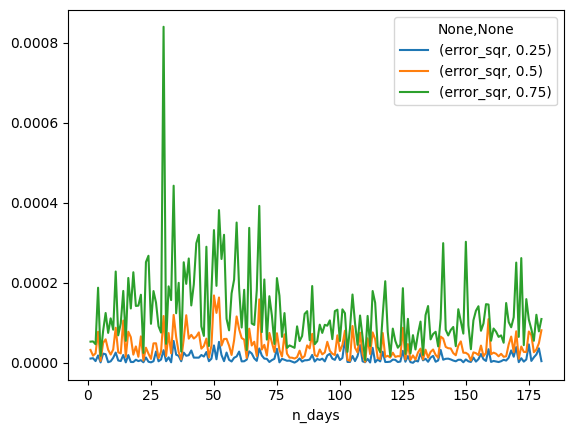

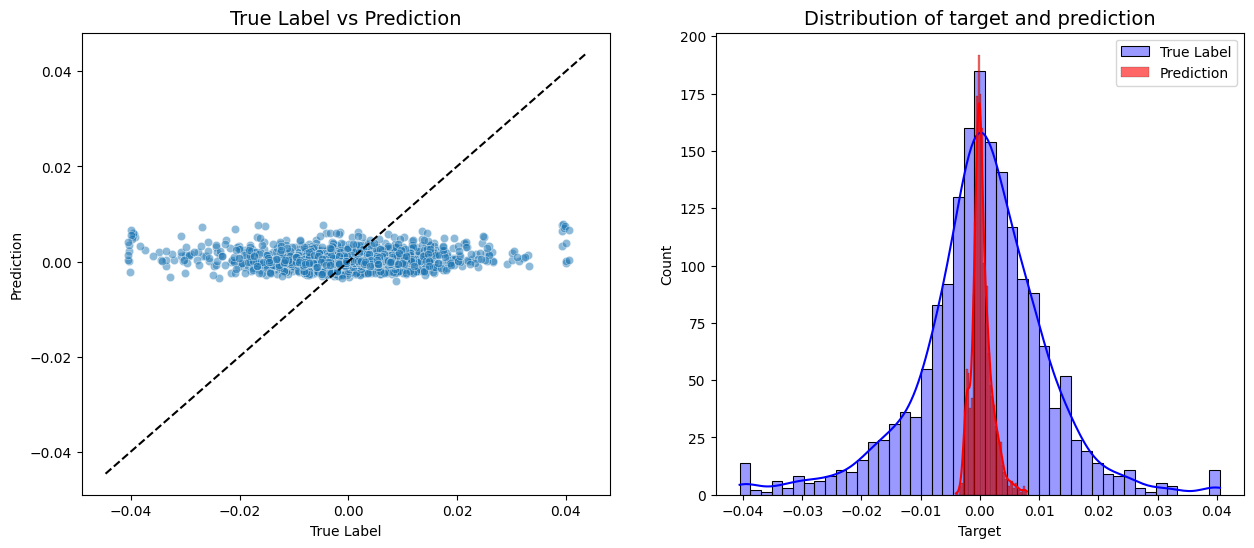

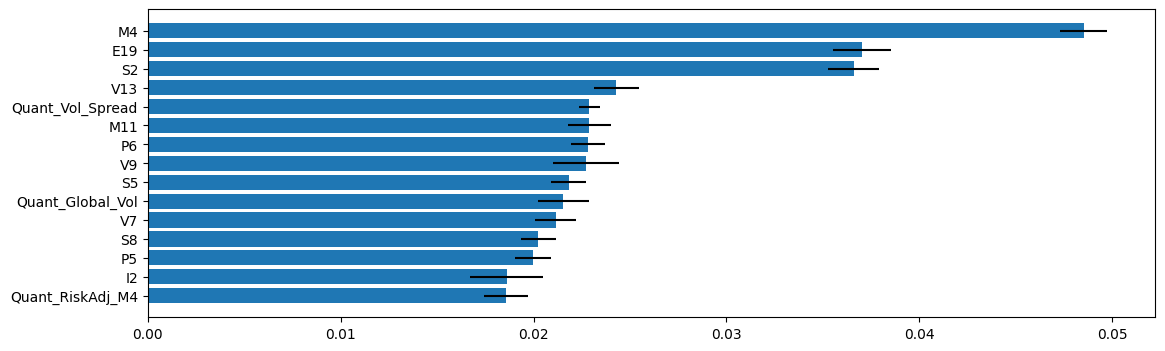

In [34]:
model = RandomForestRegressor(max_depth=20, random_state=34, n_jobs=-1, max_features=0.8, min_samples_leaf=37, n_estimators=150)

processing = Pipeline([("fe", FeatureEng(u1=False, u2=False, add_ts=True,
                                             riskadj_m4=True, quant_p11=True, fed_model=False,
                                             glob_vol=True, relmom=False, mom_div=False,
                                             mompersistence=True, momregime=False, vol_spread=True,
                                             price_mom=False, rate_sens=False)),
                            ("imputer", tml.DfImputer(strategy="constant", fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

fit_params = {"sample_weight": "date_id"}


FEATURES = [c for c in df.columns if c not in DROP]

cvscore = TSCrossValidate(data=df[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe, imp_coef=True, fit_params=fit_params)
oof, res = cvscore.score()

summary_evaluation(res["folds_eval"], df, factor=3)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="standard")

# Xgboost

In [ ]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "conversion": trial.suggest_int("conversion", 1, 10000),
        "max_depth": trial.suggest_int("max_depth", 3, 300),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 100.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 100.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3 , 300),
        "u1": trial.suggest_categorical("u1", [True, False]),
        "u2": trial.suggest_categorical("u2", [True, False]),
        "add_ts": trial.suggest_categorical("add_ts", [True, False]),
        "riskadj_m4": trial.suggest_categorical("riskadj_m4", [True, False]),
        "quant_p11": trial.suggest_categorical("quant_p11", [True, False]),
        "fed_model": trial.suggest_categorical("fed_model", [True, False]),
        "glob_vol": trial.suggest_categorical("glob_vol", [True, False]),
        "relmom": trial.suggest_categorical("relmom", [True, False]),
        "mom_div": trial.suggest_categorical("mom_div", [True, False]),
        "mompersistence": trial.suggest_categorical("mompersistence", [True, False]),
        "mom_regime": trial.suggest_categorical("mom_regime", [True, False]),
        "vol_spread": trial.suggest_categorical("vol_spread", [True, False]),
        "price_mom": trial.suggest_categorical("price_mom", [True, False]),
        "rate_sens": trial.suggest_categorical("rate_sens", [True, False]),
    }
    processing = Pipeline([("fe", FeatureEng(u1=param["u1"], u2=param["u2"], add_ts=param["add_ts"],
                                             riskadj_m4=param["riskadj_m4"], quant_p11=param["quant_p11"], fed_model=param["fed_model"],
                                             glob_vol=param["glob_vol"], relmom=param["relmom"], mom_div=param["mom_div"],
                                             mompersistence=param["mompersistence"], momregime=param["mom_regime"], vol_spread=param["vol_spread"],
                                             price_mom=param["price_mom"], rate_sens=param["rate_sens"])),
                            ("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])
    
    train = make_lags_train(data)

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = xgb.XGBRegressor(random_state=34, n_jobs=-1, early_stopping_rounds=100,
                             learning_rate=0.01,
                             n_estimators=10000,
                             subsample=param["subsample"],
                             colsample_bytree=param["colsample_bytree"],
                             reg_alpha=param["reg_alpha"],
                             reg_lambda=param["reg_lambda"],
                             max_depth=param["max_depth"],
                             colsample_bylevel=param["colsample_bylevel"],
                             eval_metric="rmse")

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id", 'verbose': False,}
    else:
        fit_params = {'verbose': False,}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params, early_stopping=True)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"] * param["conversion"] + 1, 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

: 

In [ ]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
42       42  0.995686 2025-12-01 17:53:44.727922 2025-12-01 18:25:31.835911   
164     164  0.964609 2025-12-01 21:12:16.298735 2025-12-01 21:44:21.524378   
142     142  0.948475 2025-12-01 20:32:17.323971 2025-12-01 20:56:12.012474   
137     137  0.926754 2025-12-01 20:26:54.174204 2025-12-01 20:55:59.387810   
58       58  0.912561 2025-12-01 18:25:06.246369 2025-12-01 18:49:20.393072   
25       25  0.907294 2025-12-01 17:17:48.893286 2025-12-01 18:03:59.134322   
44       44  0.904703 2025-12-01 17:58:18.989351 2025-12-01 18:30:28.921992   
89       89  0.881646 2025-12-01 19:03:48.865823 2025-12-01 19:28:44.076395   
96       96  0.881519 2025-12-01 19:21:19.277883 2025-12-01 19:46:26.591608   
172     172  0.881178 2025-12-01 21:24:31.362709 2025-12-01 22:00:02.723709   

                  duration  params_add_ts  params_colsample_bylevel  \
42  0 days 00:31:47.107989           True                  0.863385   
164 0 days 00:32:05.225643           True                  0.581991   
142 0 days 00:23:54.688503           True                  0.395146   
137 0 days 00:29:05.213606           True                  0.505824   
58  0 days 00:24:14.146703          False                  0.355250   
25  0 days 00:46:10.241036           True                  0.474870   
44  0 days 00:32:09.932641           True                  0.987860   
89  0 days 00:24:55.210572           True                  0.352361   
96  0 days 00:25:07.313725          False                  0.331698   
172 0 days 00:35:31.361000           True                  0.592141   

     params_colsample_bytree  params_conversion  params_fed_model  ...  \
42                  0.929125               1056             False  ...   
164                 0.710769                999             False  ...   
142                 0.785478               1396              True  ...   
137                 0.785654               1302             False  ...   
58                  0.734043               2899             False  ...   
25                  0.795481                697             False  ...   
44                  0.978177               1141             False  ...   
89                  0.678715               2062             False  ...   
96                  0.819358                597             False  ...   
172                 0.761345                969             False  ...   

     params_reg_lambda  params_relmom  params_riskadj_m4  \
42           59.578819           True               True   
164          87.291218          False              False   
142          61.263470          False               True   
137          63.043822          False               True   
58           50.825647          False              False   
25            1.529225           True              False   
44           84.336953          False               True   
89           92.027437          False              False   
96           56.494417          False              False   
172          58.568268          False              False   

     params_sample_weight  params_strategy  params_subsample  params_u1  \
42                   True         constant          0.723001       True   
164                  True         constant          0.656865       True   
142                  True         constant          0.700499       True   
137                  True         constant          0.939334       True   
58                   True         constant          0.719226      False   
25                   True             mean          0.673428       True   
44                   True         constant          0.846151       True   
89                   True         constant          0.819324       True   
96                   True             mean          0.580735      False   
172                  True         constant          0.740684       True   

     params_u2  params_vol_spread     state  
42   

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [26]:
{'strategy': 'constant', 'sample_weight': True, 'conversion': 1056, 'max_depth': 67, 'reg_lambda': 59.57881885355092, 'reg_alpha': 24.65082470182637, 'colsample_bytree': 0.929124819813735, 'colsample_bylevel': 0.8633851169560589, 'subsample': 0.7230012039541427, 'min_child_weight': 238.52196834847257, 'u1': True, 'u2': False, 'add_ts': True, 'riskadj_m4': True, 'quant_p11': False, 'fed_model': False, 'glob_vol': False, 'relmom': True, 'mom_div': False, 'mompersistence': True, 'mom_regime': True, 'vol_spread': False, 'price_mom': False, 'rate_sens': False}

{'strategy': 'constant',
 'sample_weight': True,
 'conversion': 1056,
 'max_depth': 67,
 'reg_lambda': 59.57881885355092,
 'reg_alpha': 24.65082470182637,
 'colsample_bytree': 0.929124819813735,
 'colsample_bylevel': 0.8633851169560589,
 'subsample': 0.7230012039541427,
 'min_child_weight': 238.52196834847257,
 'u1': True,
 'u2': False,
 'add_ts': True,
 'riskadj_m4': True,
 'quant_p11': False,
 'fed_model': False,
 'glob_vol': False,
 'relmom': True,
 'mom_div': False,
 'mompersistence': True,
 'mom_regime': True,
 'vol_spread': False,
 'price_mom': False,
 'rate_sens': False}

100%|===================| 699/700 [00:33<00:00]        

[51, 59, 48, 0, 6, 6, 11, 5, 3, 32]
Mean Squared Error: 0.00012
R2: 0.01181234297802669
MAE: 0.007905187817421735
               min      mean       max
fold                                  
0     4.822133e-10  0.000108  0.001121
1     3.214553e-11  0.000059  0.000901
2     1.135006e-07  0.000315  0.002217
3     4.571972e-11  0.000079  0.001181
4     1.570510e-12  0.000102  0.000923
5     3.034926e-09  0.000244  0.001644
6     1.294823e-13  0.000077  0.000589
7     6.253724e-10  0.000054  0.000403
8     3.881649e-13  0.000069  0.000910
9     4.308511e-09  0.000115  0.001773
Sharpe: 0.8081928325880711
0 0.5127575315614238
1 1.8869972724864517
2 0.7419115905205849
3 2.418113425833037
4 0.5892192647794843
5 -0.022037650098203933
6 2.543419814039638
7 1.803902182632174
8 1.2352705723870665
9 0.6170693836255458


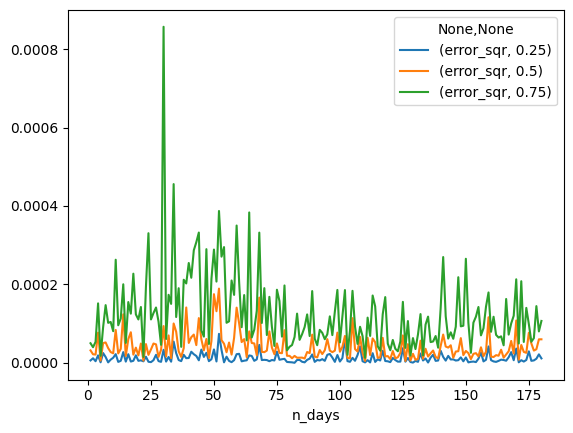

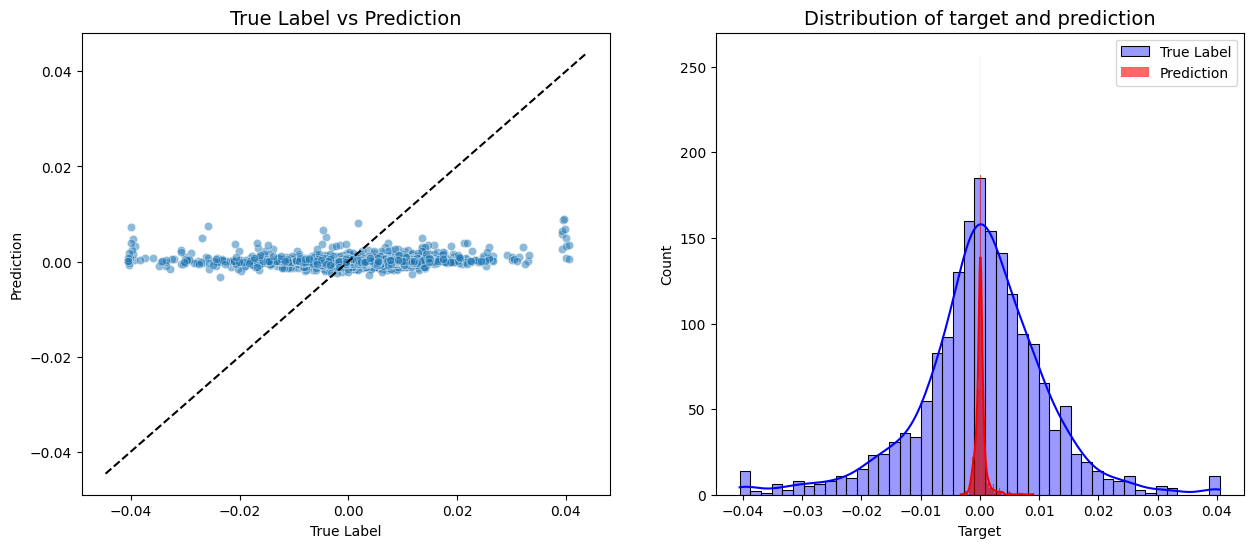

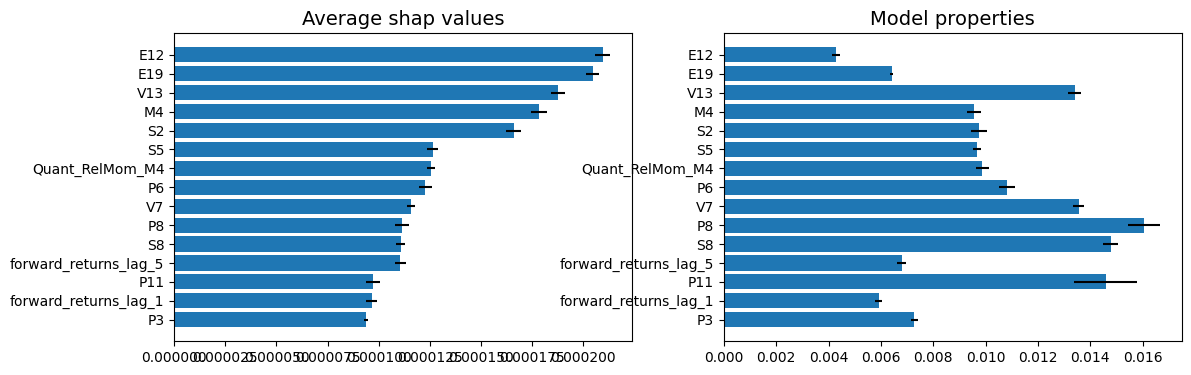

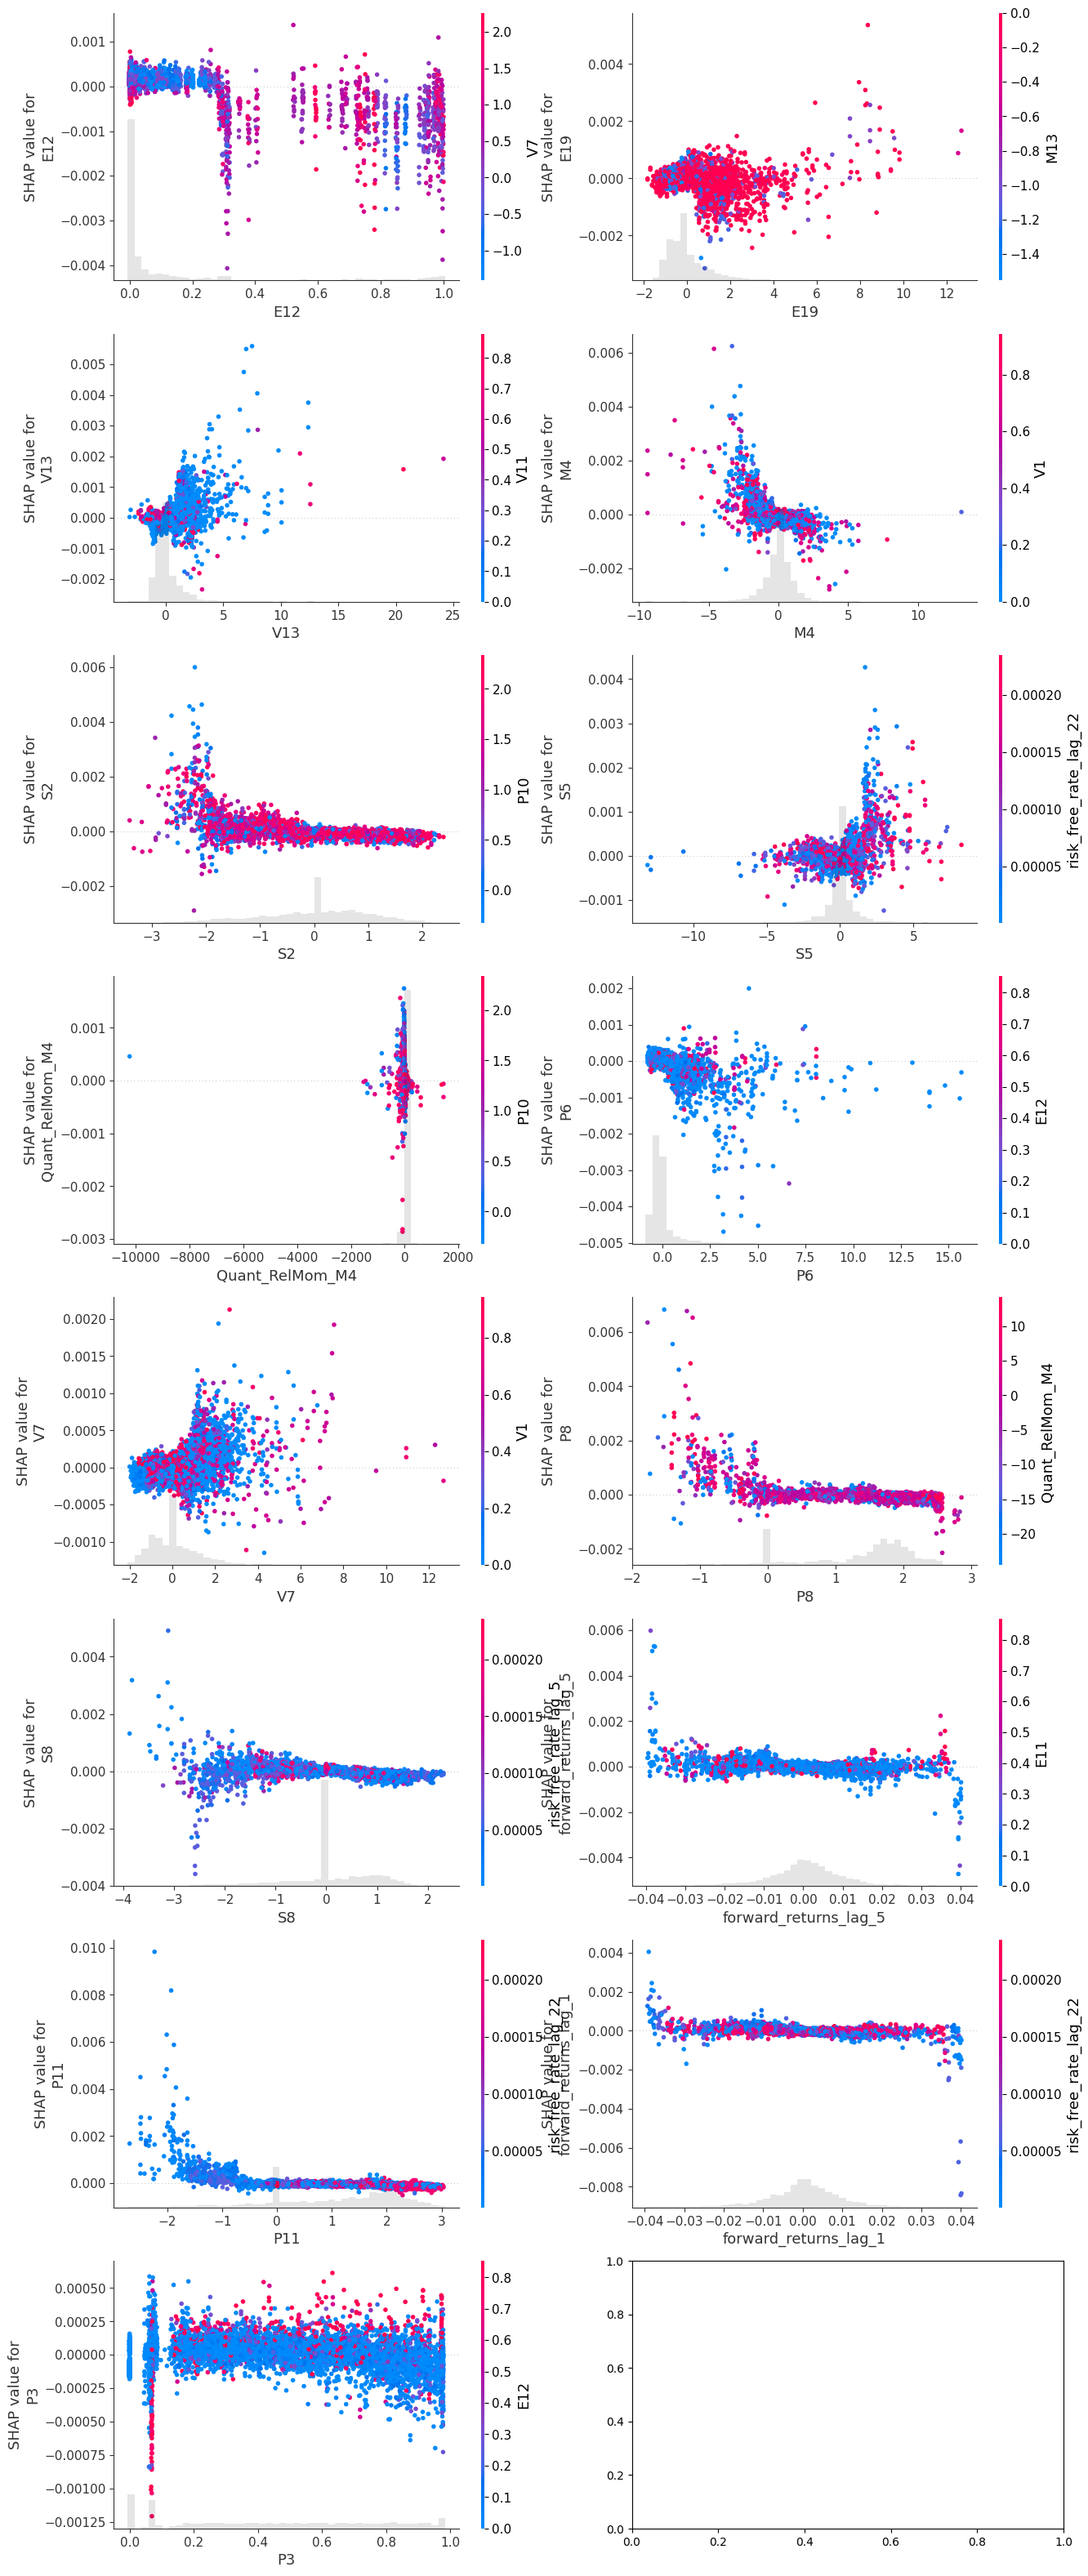

In [28]:
model = xgb.XGBRegressor(random_state=34, n_jobs=-1,
                         early_stopping_rounds=100,
                         learning_rate=0.01,
                         n_estimators=10000,
                         colsample_bylevel=0.863,
                         colsample_bytree=0.929,
                         max_depth=67,
                         min_child_weight=238.5,
                         reg_alpha=24.65,
                         reg_lambda=59.57,
                         subsample=0.723,
                         eval_metric="rmse")

fit_params = {'verbose': False, "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng(u1=True, u2=False, add_ts=True,
                                             riskadj_m4=True, quant_p11=False, fed_model=False,
                                             glob_vol=False, relmom=True, mom_div=False,
                                             mompersistence=True, momregime=True, vol_spread=False,
                                             price_mom=False, rate_sens=False)),
                            ("imputer", tml.DfImputer(strategy="constant", fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof, res = cvscore.score()

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=1000)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(15)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

# Light GBM

In [28]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "conversion": trial.suggest_int("conversion", 1, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 300),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 100.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 100.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3 , 300),
        "u1": trial.suggest_categorical("u1", [True, False]),
        "u2": trial.suggest_categorical("u2", [True, False]),
        "add_ts": trial.suggest_categorical("add_ts", [True, False]),
        "riskadj_m4": trial.suggest_categorical("riskadj_m4", [True, False]),
        "quant_p11": trial.suggest_categorical("quant_p11", [True, False]),
        "fed_model": trial.suggest_categorical("fed_model", [True, False]),
        "glob_vol": trial.suggest_categorical("glob_vol", [True, False]),
        "relmom": trial.suggest_categorical("relmom", [True, False]),
        "mom_div": trial.suggest_categorical("mom_div", [True, False]),
        "mompersistence": trial.suggest_categorical("mompersistence", [True, False]),
        "mom_regime": trial.suggest_categorical("mom_regime", [True, False]),
        "vol_spread": trial.suggest_categorical("vol_spread", [True, False]),
        "price_mom": trial.suggest_categorical("price_mom", [True, False]),
        "rate_sens": trial.suggest_categorical("rate_sens", [True, False]),
    }
    processing = Pipeline([("fe", FeatureEng(u1=param["u1"], u2=param["u2"], add_ts=param["add_ts"],
                                             riskadj_m4=param["riskadj_m4"], quant_p11=param["quant_p11"], fed_model=param["fed_model"],
                                             glob_vol=param["glob_vol"], relmom=param["relmom"], mom_div=param["mom_div"],
                                             mompersistence=param["mompersistence"], momregime=param["mom_regime"], vol_spread=param["vol_spread"],
                                             price_mom=param["price_mom"], rate_sens=param["rate_sens"])),
                            ("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                            # ("scaler", tml.DfScaler())
                            ])
    
    train = make_lags_train(data)

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                              learning_rate=0.01,
                             colsample_bytree=param["colsample_bytree"],
                             min_child_weight=param['min_child_weight'],
                             reg_lambda=param['reg_lambda'],
                             reg_alpha=param['reg_alpha'],
                             subsample=param['subsample'],
                             num_leaves=param["num_leaves"],
                             max_depth=param['max_depth'],
                             eval_metric="rmse")

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    callbacks = [lgb.early_stopping(100, verbose=0)]
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id", "callbacks":callbacks, "eval_metric": "rmse"}
    else:
        fit_params = {"callbacks":callbacks, "eval_metric": "rmse"}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params, early_stopping=True)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"] * param["conversion"] + 1, 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [33]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=500, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 500
Best trial: {'strategy': 'constant', 'sample_weight': True, 'conversion': 972, 'max_depth': 127, 'num_leaves': 67, 'reg_lambda': 58.889095287172296, 'reg_alpha': 38.05124580033062, 'colsample_bytree': 0.9582575445130066, 'subsample': 0.7888029968639777, 'min_child_weight': 298.9333242411265, 'u1': True, 'u2': True, 'add_ts': False, 'riskadj_m4': False, 'quant_p11': False, 'fed_model': False, 'glob_vol': False, 'relmom': True, 'mom_div': False, 'mompersistence': False, 'mom_regime': False, 'vol_spread': True, 'price_mom': True, 'rate_sens': False}


In [34]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
422     422  1.013660 2025-12-03 01:26:02.982584 2025-12-03 01:28:45.441555   
498     498  0.999899 2025-12-03 01:40:12.333137 2025-12-03 01:42:14.866225   
477     477  0.990873 2025-12-03 01:36:23.668093 2025-12-03 01:38:58.057019   
489     489  0.985403 2025-12-03 01:38:25.026923 2025-12-03 01:42:25.048737   
288     288  0.982670 2025-12-03 00:57:00.440847 2025-12-03 01:00:56.537315   
460     460  0.971002 2025-12-03 01:34:07.418600 2025-12-03 01:36:20.268707   
416     416  0.969132 2025-12-03 01:24:38.910269 2025-12-03 01:28:02.258858   
187     187  0.967869 2025-12-03 00:19:04.085184 2025-12-03 00:26:29.685412   
401     401  0.966989 2025-12-03 01:21:09.727976 2025-12-03 01:24:43.643723   
321     321  0.964644 2025-12-03 01:04:23.481897 2025-12-03 01:08:32.212256   

                  duration  params_add_ts  params_colsample_bytree  \
422 0 days 00:02:42.458971          False                 0.958258   
498 0 days 00:02:02.533088          False                 0.918684   
477 0 days 00:02:34.388926          False                 0.937434   
489 0 days 00:04:00.021814          False                 0.853447   
288 0 days 00:03:56.096468          False                 0.959783   
460 0 days 00:02:12.850107          False                 0.970632   
416 0 days 00:03:23.348589          False                 0.999171   
187 0 days 00:07:25.600228          False                 0.969893   
401 0 days 00:03:33.915747          False                 0.960024   
321 0 days 00:04:08.730359          False                 0.935054   

     params_conversion  params_fed_model  params_glob_vol  params_max_depth  \
422                972             False            False               127   
498                986             False            False               136   
477                963             False            False               144   
489                963             False            False               137   
288                964             False            False               128   
460                939             False            False               154   
416                859             False            False               129   
187                850             False            False               175   
401                913             False            False               140   
321                922             False            False               145   

     params_min_child_weight  params_mom_div  params_mom_regime  \
422               298.933324           False              False   
498               293.790889           False               True   
477               293.026554           False              False   
489               293.342685           False               True   
288               290.424339           False              False   
460               282.107427           False               True   
416               299.895689           False              False   
187               285.958413           False              False   
401               262.746749           False              False   
321               298.562554           False              False   

     params_mompersistence  params_num_leaves  params_price_mom  \
422                  False                 67              True   
498                  False                 42              True   
477                  False                 51              True   
489                  False                109              True   
288                  False                100              True   
460                  False                 47              True   
416                  False                 94              True   
187                  False                114              True   
401                  False                 93              True   
321                  False                101              True   

     params_quant_

In [35]:
optuna.visualization.plot_optimization_history(study)

In [36]:
optuna.visualization.plot_param_importances(study)

In [23]:
{'strategy': 'median', 'sample_weight': True, 'conversion': 766, 'max_depth': 290, 'num_leaves': 75, 'reg_lambda': 57.71962935447598, 'reg_alpha': 36.91854548325229, 'colsample_bytree': 0.999487545779019, 'subsample': 0.578721731071197, 'min_child_weight': 28.121899348822225, 'u1': False, 'u2': False, 'add_ts': False, 'riskadj_m4': False, 'quant_p11': True, 'fed_model': False, 'glob_vol': True, 'relmom': True, 'mom_div': False, 'mompersistence': False, 'mom_regime': True, 'vol_spread': False, 'price_mom': False, 'rate_sens': True}

{'strategy': 'median',
 'sample_weight': True,
 'conversion': 766,
 'max_depth': 290,
 'num_leaves': 75,
 'reg_lambda': 57.71962935447598,
 'reg_alpha': 36.91854548325229,
 'colsample_bytree': 0.999487545779019,
 'subsample': 0.578721731071197,
 'min_child_weight': 28.121899348822225,
 'u1': False,
 'u2': False,
 'add_ts': False,
 'riskadj_m4': False,
 'quant_p11': True,
 'fed_model': False,
 'glob_vol': True,
 'relmom': True,
 'mom_div': False,
 'mompersistence': False,
 'mom_regime': True,
 'vol_spread': False,
 'price_mom': False,
 'rate_sens': True}

[3, 40, 1, 3, 24, 41, 5, 12, 122, 16]
Mean Squared Error: 0.00012
R2: 0.006246637511352238
MAE: 0.007905738069781261
               min      mean       max
fold                                  
0     6.363448e-10  0.000110  0.001531
1     1.134629e-09  0.000059  0.000955
2     1.664789e-10  0.000322  0.001633
3     5.823726e-10  0.000079  0.001200
4     1.420605e-09  0.000102  0.000976
5     2.903704e-08  0.000242  0.001657
6     4.424042e-09  0.000078  0.000608
7     2.047648e-10  0.000054  0.000404
8     2.231624e-11  0.000069  0.000916
9     1.651314e-09  0.000115  0.001735
Sharpe: 0.9925641572934224
0 -0.044255380168502764
1 1.6263606408927531
2 0.5258309519259351
3 2.484453936821102
4 0.538077979754721
5 0.6126620631289793
6 1.3210019027686615
7 1.6567722863219716
8 1.264142115180704
9 1.100637010722263


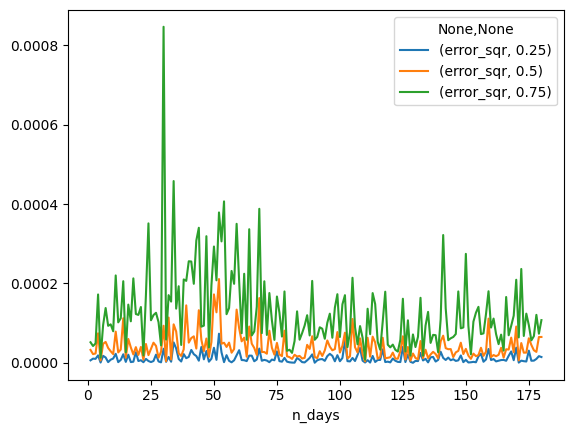

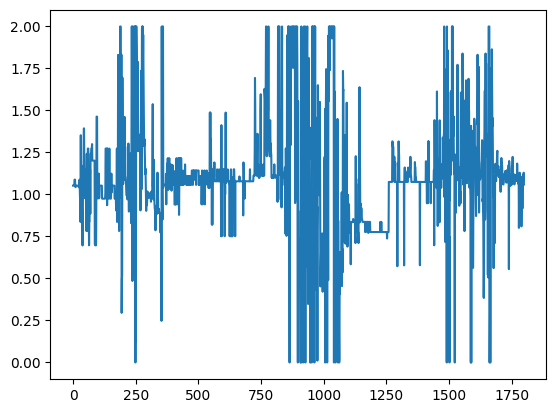

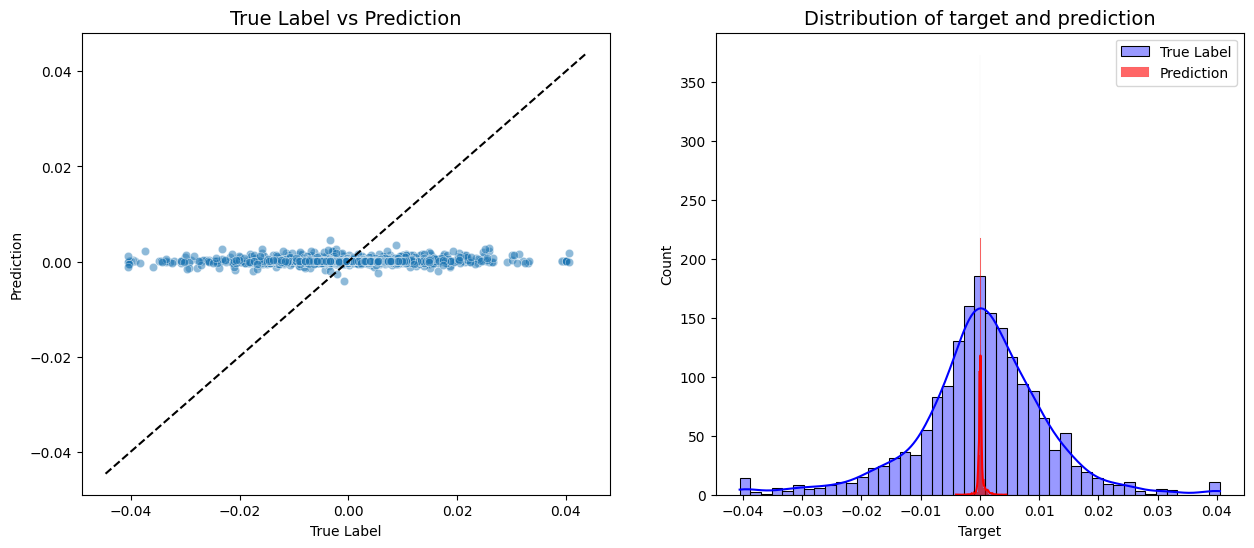

In [40]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.95,
                             min_child_weight=299,
                             reg_lambda=58,
                             reg_alpha=38,
                             subsample=0.788,
                             num_leaves=67,
                             max_depth=127)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng(u1=True, u2=True, add_ts=False,
                                             riskadj_m4=False, quant_p11=False, fed_model=False,
                                             glob_vol=False, relmom=True, mom_div=False,
                                             mompersistence=False, momregime=False, vol_spread=True,
                                             price_mom=True, rate_sens=False)),
                            ("imputer", tml.DfImputer(strategy="constant", fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

train = make_lags_train(df)

FEATURES = [c for c in train.columns if c not in DROP]

cvscore = TSCrossValidate(data=train[FEATURES], target=train[TARGET], cv=ts_folds, estimator=pipe, shap=False, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof, res = cvscore.score()

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=970)

# tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

# to_plot = res["feat_imp"].head(15)["Feature"].to_list()
# tml.plot_shap_values(res["shap_values"], features=to_plot)